# Simulación del Péndulo Invertido con PID Optimizado por Q-Learning
Este notebook permite realizar una simulación del péndulo invertido controlado mediante un PID cuyos valores (Kp, Ki, Kd) se optimizan utilizando las tablas Q aprendidas.

In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from inverted_pendulum import InvertedPendulum
from controller import PIDController
from simulator import PendulumControl
from reinforcement_learning import discretize_state
from config import config

In [4]:
# Cargar las tablas Q y eliminar columnas no necesarias
qtable_kp = pd.read_csv('qtable_kp.csv').iloc[:, 1:]  # Ignorar 'Unnamed: 0'
qtable_ki = pd.read_csv('qtable_ki.csv').iloc[:, 1:]  # Ignorar 'Unnamed: 0'
qtable_kd = pd.read_csv('qtable_kd.csv').iloc[:, 1:]  # Ignorar 'Unnamed: 0'

# Verificar si las tablas contienen las columnas esperadas
expected_columns = ['action_0', 'action_1', 'action_2']
for qtable, name in zip([qtable_kp, qtable_ki, qtable_kd], ['kp', 'ki', 'kd']):
    if not all(col in qtable.columns for col in expected_columns):
        raise ValueError(f"La tabla Q para {name} no contiene las columnas esperadas: {expected_columns}")

In [6]:
# Función para seleccionar acciones basadas en las tablas Q
def choose_action_from_qtable(state_dict, qtable):
    state_index = discretize_state(state_dict, config['state'], [col for col in qtable.columns if col not in ['action_0', 'action_1', 'action_2']])
    q_values = qtable.iloc[state_index][['action_0', 'action_1', 'action_2']]  # Filtrar solo columnas de acciones
    
    # Verificar si q_values es una Serie o un DataFrame
    if isinstance(q_values, pd.Series):
        action = q_values.idxmax()  # Obtener el índice de la acción
    else:
        action = q_values.idxmax(axis=1).values[0]  # Obtener el índice de la acción en caso de DataFrame
    
    # Validar que el índice corresponde a una acción válida
    if action.startswith('action_'):
        return int(action.split('_')[1])
    else:
        # Imprimir las columnas y valores para depurar
        print("Estado actual:", state_dict)
        print("Q-table columnas:", qtable.columns)
        print("Valores de Q:", q_values)
        raise ValueError(f"Formato de acción inesperado: {action}")

In [8]:
# Configuración del sistema
pendulum = InvertedPendulum(**config['physical'])
setpoint = config['controller']['setpoint']
kp, ki, kd = config['controller']['kp'], config['controller']['ki'], config['controller']['kd']
gain_step = config['controller']['gain_step']  # Paso de ajuste de las ganancias
pid_controller = PIDController(kp, ki, kd, setpoint, config['simulation']['dt'], gain_step=gain_step)

In [10]:
# Simulación del sistema
state = config['physical']['x0']
time_steps = int(config['simulation']['total_time'] / config['simulation']['dt'])
results = {
    'time': [], 'cart_position': [], 'cart_velocity': [], 'pendulum_angle': [], 'pendulum_velocity': [],
    'kp': [], 'ki': [], 'kd': []
}

for t in range(time_steps):
    error = setpoint - state[2]
    
    # Convertir el estado en un diccionario para discretización
    state_dict = {
        'angle': state[2],
        'angular_velocity': state[3],
        'kp': pid_controller.kp,
        'ki': pid_controller.ki,
        'kd': pid_controller.kd
    }
    
    # Calcular la acción desde las tablas Q
    actions = {
        'kp': choose_action_from_qtable(state_dict, qtable_kp),
        'ki': choose_action_from_qtable(state_dict, qtable_ki),
        'kd': choose_action_from_qtable(state_dict, qtable_kd)
    }
    
    # Ajustar las ganancias del controlador según las acciones y el gain_step
    pid_controller.kp += (actions['kp'] - 1) * gain_step  # 0: bajar, 1: mantener, 2: subir
    pid_controller.ki += (actions['ki'] - 1) * gain_step
    pid_controller.kd += (actions['kd'] - 1) * gain_step
    
    # Calcular fuerza de control
    force = pid_controller.compute(error)
    
    # Actualizar estado del péndulo
    state = pendulum.update(state, t * config['simulation']['dt'], config['simulation']['dt'], force)
    
    # Registrar resultados
    results['time'].append(t * config['simulation']['dt'])
    results['cart_position'].append(state[0])
    results['cart_velocity'].append(state[1])
    results['pendulum_angle'].append(state[2])
    results['pendulum_velocity'].append(state[3])
    results['kp'].append(pid_controller.kp)
    results['ki'].append(pid_controller.ki)
    results['kd'].append(pid_controller.kd)

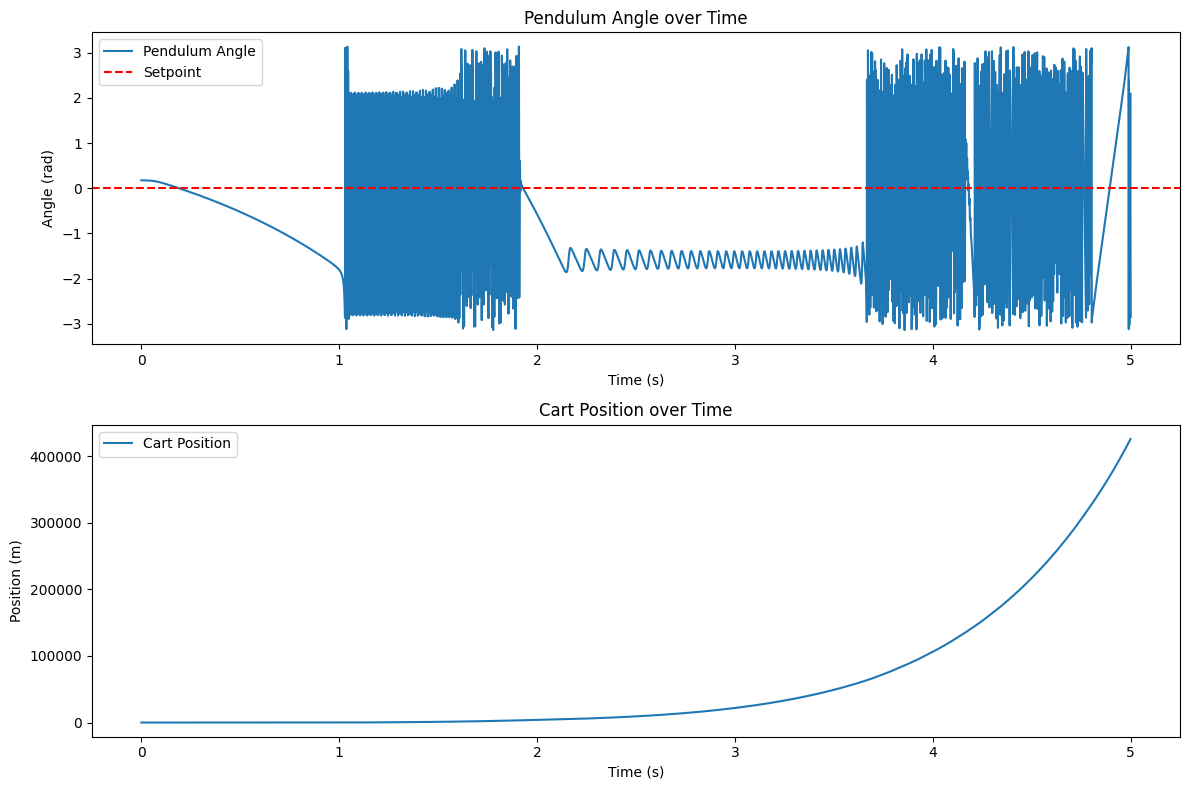

In [12]:
# Visualización de resultados
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(results['time'], results['pendulum_angle'], label='Pendulum Angle')
plt.axhline(y=0, color='r', linestyle='--', label='Setpoint')
plt.title('Pendulum Angle over Time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(results['time'], results['cart_position'], label='Cart Position')
plt.title('Cart Position over Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()

plt.tight_layout()
plt.show()